
# Training a TFNO on Darcy-Flow

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

from gc_src.gc_opt import GCOptimizer, WarmupScheduler

device = 'cuda:0'

Loading the Navier-Stokes dataset in 128x128 resolution



In [2]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=5000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        positional_encoding=True
)
data_processor = data_processor.to(device)

Loading test db at resolution 32 with 50 samples and batch-size=32


We create a tensorized FNO model



In [3]:
model = TFNO(n_modes=(64, 64), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 7509017 parameters.


Create the optimizer



In [4]:
base_optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(base_optimizer, T_max=99999999)
#contvar0 = float('nan')
contvar0 = 1e-5
contlr = 5e-1
warmup = 5
optimizer = GCOptimizer(base_optimizer, cont_var0 = contvar0, cont_lr = contlr)
warmupscheduler = WarmupScheduler(optimizer, warmup_epochs = warmup)

# n-modes = (32, 32)
# nan - 0.114 0.0996 0.0807 0.0996 0.0708 0.0863 0.0861 0.123 0.0667 0.0740 - 0.0901
# 1e-6 wu 0 lr 5e-2 - 0.0890 0.0722 0.0952 0.0835 0.0905 0.0854 0.0644 0.105 0.0824 0.0612 - 0.0829
# 1e-6 wu 0 lr 1e-1 - 0.0668 0.0719 0.0948 0.0771 0.0957 0.0751 0.102 0.0804 0.0912 0.0709 - 0.0826

Creating the losses



In [5]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [6]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 64, 33), rank=(26, 26, 51, 27))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 GCOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neura

Create the trainer



In [7]:
trainer = Trainer(model=model, n_epochs=50,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


Actually train the model on our small Darcy-Flow dataset



In [8]:
'''trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)'''

'trainer.train(train_loader=train_loader,\n              test_loaders=test_loaders,\n              optimizer=optimizer,\n              scheduler=scheduler, \n              regularizer=False, \n              training_loss=train_loss,\n              eval_losses=eval_losses)'

In [9]:
for epoch in range(trainer.n_epochs):
    model.train()
    train_err = 0.0
    train_samples = 0

    for idx, sample in enumerate(train_loader):
        if trainer.data_processor is not None:
            sample = trainer.data_processor.preprocess(sample)
        else:
            # load data to device if no preprocessor exists
            sample = {
                k: v.to(self.device)
                for k, v in sample.items()
                if torch.is_tensor(v)
            }
        
        train_samples += sample["y"].shape[0]

        def closure():
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward
            out = model(**sample)
            loss = train_loss(out, **sample)
            loss.backward()
            del out

            return loss

        loss = optimizer.step(closure)
        train_err += loss.item()

    scheduler.step()
    warmupscheduler.step()

    # test error
    model.eval()
    test_err = 0.0
    test_samples = 0
    test_loader = test_loaders[16]

    for idx, sample in enumerate(test_loader):
        if trainer.data_processor is not None:
            sample = trainer.data_processor.preprocess(sample)
        else:
            # load data to device if no preprocessor exists
            sample = {
                k: v.to(self.device)
                for k, v in sample.items()
                if torch.is_tensor(v)
            }

        test_samples += sample["y"].shape[0]

        with torch.no_grad():
            out = model(**sample)
            loss = eval_losses['h1'](out, **sample)
            test_err += loss.item()
            del out

    train_err /= train_samples
    test_err /= test_samples

    print(f'Epoch {epoch}, train loss: {train_err:.6f}, test loss: {test_err:.6f}, optim contvar: {torch.exp(optimizer.logcontvar).detach():.2e}, optim lr: {optimizer.param_groups[0]["lr"]:.2e}')

with open(f'res_{contvar0:.1e}_{contlr:.1e}_{warmup}.txt', "a") as myfile:
    myfile.write(f'{train_err:.6f}, {test_err:.6f}, {torch.exp(optimizer.logcontvar).detach():.2e}\n')


Epoch 0, train loss: 3.371322, test loss: 0.968493, optim contvar: 1.00e-05, optim lr: 8.00e-03
Epoch 1, train loss: 0.961308, test loss: 0.975159, optim contvar: 1.00e-05, optim lr: 8.00e-03
Epoch 2, train loss: 0.744018, test loss: 0.645036, optim contvar: 1.00e-05, optim lr: 8.00e-03
Epoch 3, train loss: 0.497432, test loss: 0.497283, optim contvar: 1.00e-05, optim lr: 8.00e-03
Epoch 4, train loss: 0.409234, test loss: 0.400199, optim contvar: 1.00e-05, optim lr: 8.00e-03
Epoch 5, train loss: 0.339977, test loss: 0.360551, optim contvar: 1.63e-08, optim lr: 8.00e-03
Epoch 6, train loss: 0.304193, test loss: 0.319325, optim contvar: 7.52e-09, optim lr: 8.00e-03
Epoch 7, train loss: 0.276086, test loss: 0.299123, optim contvar: 6.83e-09, optim lr: 8.00e-03
Epoch 8, train loss: 0.287390, test loss: 0.287391, optim contvar: 1.40e-08, optim lr: 8.00e-03
Epoch 9, train loss: 0.269004, test loss: 0.300756, optim contvar: 1.00e-08, optim lr: 8.00e-03
Epoch 10, train loss: 0.259964, test los

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



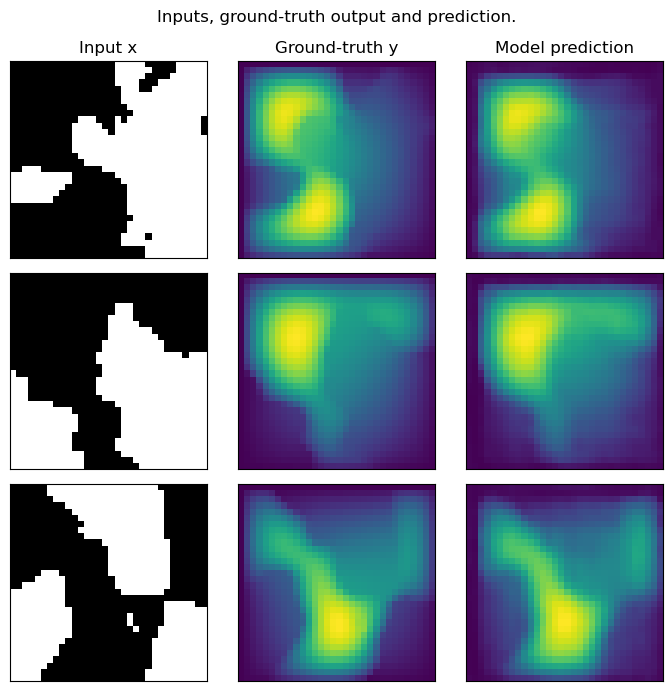

In [10]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().cpu())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().cpu().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()